# Elliptic Example: 2D Laplacian

We want to model the electric potential for an empty 2D box, 10cm x 10cm in size, where the top wall is held at $V$ = 1.0V and the other walls at 0V.

$$0 = \nabla^2 \phi  = \frac{\partial^2 \phi}{\partial x^2} + \frac{\partial^2 \phi}{\partial y^2},$$
$$ \phi(y = 10) = 1.0 V$$
$$ \phi(y = 0) = \phi(x = 0) = \phi(x = 10) = 0$$

![](fig9-2.png)

## Exercise 1

Setup up the problem: 
* discretize space in x and y, using an MxM grid
* implement the boundary conditions

Then use Jacobi Relaxation to solve it, with target accuracy 1e-04 and M=10. Print the number of iterations required to reach the target accuracy.

You can consult the textbook's `laplace.py` for help.

In [1]:
from numpy import empty,zeros,max
from pylab import imshow,gray,show

M = 10
V = 1.0
target = 1e-4

phi = zeros([M+1,M+1],float)
phi[0,:] = V
phiprime = empty([M+1,M+1],float)

delta = 1.0
iterations = 0
while delta>target:

    for i in range(M+1):
        for j in range(M+1):
            if i==0 or i==M or j==0 or j==M:
                phiprime[i,j] = phi[i,j]
            else:
                phiprime[i,j] = (phi[i+1,j] + phi[i-1,j] \
                                 + phi[i,j+1] + phi[i,j-1])/4

    delta = max(abs(phi-phiprime))
    phi,phiprime = phiprime,phi
    iterations += 1

print(f"Number of iterations required to reach target accuracy: {iterations}")

Number of iterations required to reach target accuracy: 106


## Exercise 2

Plot the solution (you can use matplotlib.pyplot.imshow)

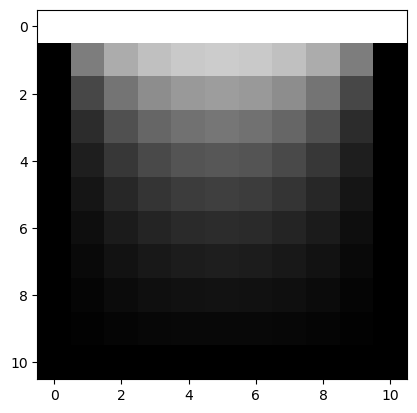

In [2]:
# Make a plot of the potential distribution
imshow(phi)
gray()
show()

## Exercise 3

Now repeat Exercises 1 and 2 with M=100. Do you notice a difference in runtime?

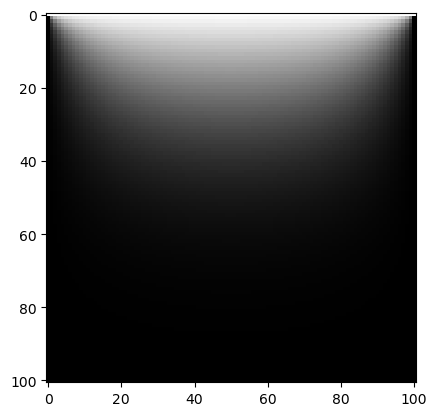

Number of iterations required to reach target accuracy: 1909


In [3]:
M = 100
V = 1.0
target = 1e-4

phi = zeros([M+1,M+1],float)
phi[0,:] = V
phiprime = empty([M+1,M+1],float)

delta = 1.0
iterations = 0
while delta>target:

    for i in range(M+1):
        for j in range(M+1):
            if i==0 or i==M or j==0 or j==M:
                phiprime[i,j] = phi[i,j]
            else:
                phiprime[i,j] = (phi[i+1,j] + phi[i-1,j] \
                                 + phi[i,j+1] + phi[i,j-1])/4

    delta = max(abs(phi-phiprime))
    phi,phiprime = phiprime,phi
    iterations += 1

imshow(phi)
gray()
show()

print(f"Number of iterations required to reach target accuracy: {iterations}")

# Hyperbolic Example: Wave Equation

Recall the 1D wave equation:
$$ \frac{\partial^2\phi}{\partial t^2}=v^2\frac{\partial^2\phi}{\partial x^2} $$
Consider a piano string of length $L$, initially at rest. At time $t=0$ the string is struck by the piano hammer a distance $d$ from the end of from the string. The string vibrates as a result of being struck, except at the ends, $x=0$, and $x=L$, where it is held fixed.

Consider the case $v=100\mathrm{ms^{-1}}$, with the initial condition that $\phi(x)=0$ everywhere but the velocity $\psi(x)$ is nonzero, with profile
\begin{equation}
  \psi(x) = C\frac{x(L-x)}{L^2}\exp\left[-\frac{(x-d)^2}{2\sigma^2}\right],
\end{equation}
where $L=1$m, $d=10$cm, $C=1\mathrm{ms^{-1}}$, and $\sigma=0.3$m. 

## Exercise 4

Solve using the FTCS method, with grid spacing (in $x$) $a=5$ mm, from times 0 to 0.1s using time--step $h=10^{-6}$ s.
Make a plot of $\phi$ vs $x$ over the entire length of string, at each of the following times:
* 0.006 s
* 0.004 s
* 0.002 s
* 0.012 s
* 0.100 s

You'll see your first 4 plots look good, then the instability of the solution shows up!

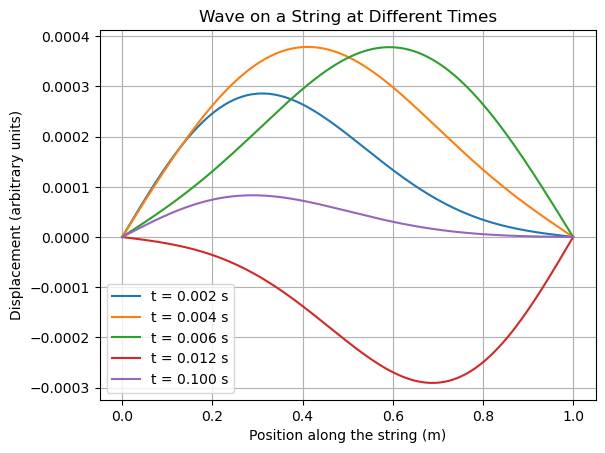

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
v = 100  # Wave speed (m/s)
L = 1.0  # Length of the string (m)
C = 1.0  # Initial velocity profile scaling factor (m/s)
d = 0.1  # Distance from the end where the string is struck (m)
sigma = 0.3  # Width of the Gaussian (m)
a = 0.005  # Grid spacing (m)
h = 1e-6  # Time step (s)
N = int(L / a)
x = np.linspace(0, L, N)
time_steps = int(0.1 / h) + 1 

phi = np.zeros(N)
phi_new = np.zeros(N)
phi_old = np.zeros(N)

psi = C * x * (L - x) / L**2 * np.exp(-((x - d)**2) / (2 * sigma**2))
phi_old = -psi * h

times_to_plot = [0.006, 0.004, 0.002, 0.012, 0.1]
time_indices = [int(t / h) for t in times_to_plot]

# Time evolution
for t in range(time_steps):
    for i in range(1, N - 1):
        phi_new[i] = 2 * phi[i] - phi_old[i] + (v * h / a)**2 * (phi[i+1] - 2*phi[i] + phi[i-1])
    
    phi_old, phi = phi, phi_new.copy()
    
    if t in time_indices:
        time_label = times_to_plot[time_indices.index(t)]
        plt.plot(x, phi, label=f't = {time_label:.3f} s')

plt.xlabel("Position along the string (m)")
plt.ylabel("Displacement (arbitrary units)")
plt.title("Wave on a String at Different Times")
plt.legend()
plt.grid()
plt.show()

## Exercise 5

Repeat the previous exercise using the Crank--Nicolson method. Use a larger time--step, $h = 10^{-4}$ s.

You'll see the solution is stable. It dies out to 0 at about 0.1 s, but this is how the physical system is supposed to behave!

the CN method involves a set of simultaneous equations, one for each grid point. We can solve using the methods for linear systems in Chapter 6 -- in particular, banded matrix. The following snippets of code will help you define the matrix, and the vector to use on the right-hand side, of the CK equations.

In [5]:
def matrix(N,alpha):
    """Banded matrix for the Crank-Nicolson
    Args: 
        N : number of elements
        alpha = 2*h*v**2/a**2 , h: timestep length, a: spatial grid spacing, v: wave speed"""
    bands = np.zeros((3,N+2))
    bands[0,:-2] = -alpha
    bands[2,1:-1] = -alpha
    bands[1,:] = 1+2*alpha
    return bands 

def banded(Aa,va,up=1,down=1):
# from textbook online resources, to solve Ax = v
# Aa is banded matrix A, va is vector v, up and down give band positions in matrix

    # Copy the inputs and determine the size of the system
    A = np.copy(Aa)
    v = np.copy(va)
    N = len(v)

    # Gaussian elimination
    for m in range(N):

        # Normalization factor
        div = A[up,m]

        # Update the vector first
        v[m] /= div
        for k in range(1,down+1):
            if m+k<N:
                v[m+k] -= A[up+k,m]*v[m]

        # Now normalize the pivot row of A and subtract from lower ones
        for i in range(up):
            j = m + up - i
            if j<N:
                A[i,j] /= div
                for k in range(1,down+1):
                    A[i+k,j] -= A[up+k,m]*A[i,j]

    # Backsubstitution
    for m in range(N-2,-1,-1):
        for i in range(up):
            j = m + up - i
            if j<N:
                v[m] -= A[i,j]*v[j]

    return v

In [6]:
def rhs(phi, psi, alpha,h):
    """Solve the Right hand side of the Crank-Nicolson algorithm.
    Args:
        phi, psi : position and velocity
        alpha = 2*h*v**2/a**2,
        h=dt, timestep
    
    Returns:
    the column vector for the right hand side.
    """
    r = np.zeros_like(phi)
    r[1:-1] = (h*psi[1:-1] + 
               alpha * phi[:-2] +
               (1-2*alpha)*phi[1:-1] + 
               alpha * phi[2:])
    return r

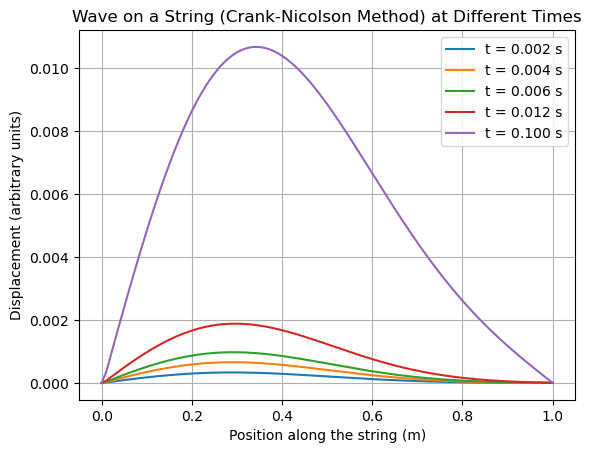

In [50]:
import numpy as np
import matplotlib.pyplot as plt

v = 100.0
L = 1.0
C = 1.0
d = 0.1
sigma = 0.3
a = 0.005
h = 1e-4
N = int(L / a)
x = np.linspace(0, L, N)

alpha = (v * h / (2 * a))**2

phi = np.zeros(N)
phi_old = np.zeros(N)
phi_new = np.zeros(N)

psi = C * x * (L - x) / L**2 * np.exp(-((x - d)**2) / (2 * sigma**2))
phi_old = -psi * h

times_to_plot = [0.002, 0.004, 0.006, 0.012, 0.1]
time_steps = int(times_to_plot[-1] / h) + 1
results = {}

A = matrix(N - 2, alpha)

for t in range(time_steps):
    rhs_vector = rhs(phi, psi, alpha, h)
    phi_interior = banded(A, rhs_vector[1:-1], up=1, down=1)
    phi_new[1:-1] = phi_interior
    phi_new[0] = phi_new[-1] = 0
    phi_old, phi = phi, phi_new.copy()
    current_time = (t + 1) * h
    for target_time in times_to_plot:
        if abs(current_time - target_time) < h / 2:
            results[target_time] = phi.copy()

for target_time in sorted(results.keys()):
    plt.plot(x, results[target_time], label=f't = {target_time:.3f} s')

plt.xlabel("Position along the string (m)")
plt.ylabel("Displacement (arbitrary units)")
plt.title("Wave on a String (Crank-Nicolson Method) at Different Times")
plt.legend()
plt.grid()
plt.show()
